# The Gaussian copula and the meta-Gaussian distribution

In [1]:
%matplotlib inline
import elfi
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from elfi.examples import copula as copula_example_model
import elfi.methods.copula as cop

Let $X$ be an absolutely continuous distribution with CDF $F$ and marginal CDFs $F_i$. A copula $C$ is a function on $[0, 1]^p$ such that
$$F(x_i, \dots, x_p) = C(F_i(x_1), \dots, F_p(x_p))$$

The density of a copula is defined as
$$c = \frac{\partial^p C}{\partial F_1, \dots, \partial F_p}$$.

The joint distribution of $X$ can now be written as
$$f(x) = c(F_i(x_1), \dots, F_p(x_p)) \prod_{i=1}^p f_i(x_i)$$

Since a multivariate Gaussian distribution can be written as
$$\frac{1}{|R|^{\frac12}} \exp \left\{ -\frac12 u^T (R^{-1} - I) u \right\} \prod_{i=1}^p \frac{1}{\sigma_i}\phi(u_i)$$,
where $u_i = \Phi^{-1}(F_i(x_i))$, we get the Gaussian copula to be
$$\frac{1}{|R|^{\frac12}} \exp \left\{ -\frac12 u^T (R^{-1} - I) u \right\}$$ when we allow arbitrary distribution functions $F_i$. The resulting ddistribution is called a meta-Gaussian distribution with a a density function
$$\frac{1}{|R|^{\frac12}} \exp \left\{ -\frac12 u^T (R^{-1} - I) u \right\} \prod_{i=1}^p f_i(x_i)$$

The meta-Gaussian distribution has the useful propery that the joint distribution is fully specified by the marginal distributions and the pairwise correlations between the different components. This allows us to construct an estimate of the full distribution using by estimating univariate marginal distributions and correlations between them. The use of the meta-Gaussian distribution in ABC applications is justified by asymptotic normality in [ref].

A meta-Gaussian distribution can be constructed in ELFI by specifying the marginal distributions and the correlation matrix. The marginal distributions can be any objects which implement the `cdf` and `ppf` methods, for example distributions from scipy. Here we define a meta-Gaussian distribution with beta and gamma distributed marginals and a correlation of 0.9.

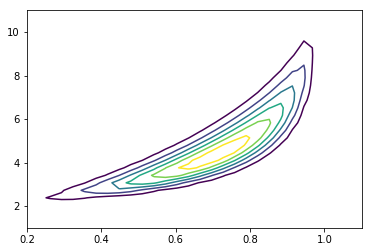

In [2]:
from elfi.utils import tabulate

rho = 0.9
corr = np.array([[1, rho],
                 [rho, 1]])
marginals = [ss.beta(5, 2),
             ss.gamma(3, 2)]

mg = cop.MetaGaussian(corr=corr, marginals=marginals)

t1 = np.linspace(0.2, 1.1, 30)
t2 = np.linspace(1, 11, 30)
grid, vals = tabulate(mg.pdf, t1, t2)
plt.contour(*grid, vals);

The marginal distributions can also be estimated from data using the `EmpiricalDensity` class. It estimates the density function using a Gaussian kernel density estimate and the cumulative distribution function using linear interpolation of the empirical CDF.

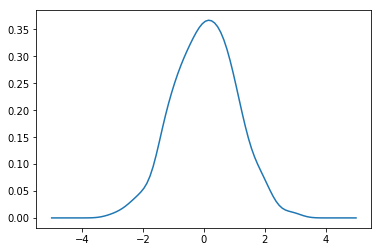

In [3]:
from elfi.methods.empirical_density import EmpiricalDensity
density_estimate = EmpiricalDensity(np.random.randn(1000))

t = np.linspace(-5, 5, 100)
plt.plot(t, density_estimate.pdf(t));

In [4]:
# def transform(x, b=0.1):
#     nx = x.copy()
#     nx[1] = nx[1] + b*nx[0]**2 - 100*b
#     return nx

# def inverse(y, b=0.1):
#     ny = y.copy()
#     ny[1] = 100*b - b*ny[0]**2 + ny[1]
#     return ny

According to the Bernstein-von Mises theorem the posterior $\pi(\theta \mid y_{obs})$ is asymptotically normal. [ref] uses this fact to approach ABC inference from a structured approach to density estimation. In this approach the $p$-dimensional posterior is approximated using a meta-Gaussian distribution. Meta-Gaussian distributions have the property that the full joint distribution can be approximated from all bivariate marginals. This allows us to estimate the lower dimensional marginal distributions separately and in parallel.

In [5]:
# We will use a simple toy example to illustrate this. Assume that the data $y$ is generated from a multivariate Gaussian $y \sim N_p(\theta, I)$, $p \geq 2$. We use a "twisted" Gaussian distribution as our prior, which is obtained by transforming the Gaussian distribution $N(0, \Sigma)$, where $\Sigma = \text{diag}([100, 1, 1, \dots, 1])$ by the function $\phi_b(x) = (x_1, x_2 + b x_1^2 - 100 b, x_3, \dots, x_p$). We use $b=0.1$ to get a strong correlation between the first two components.

# We use $y_{obs} = [10, 0, \dots, 0]$ as the oberved data. We use the identity function as the summary statistic $s = S(y) = y$. Exploting our knowledge of the model, we set the subset of the summary informative about $\theta_i$ to be $s_i$ with the expection of the second component which we set to $s_{(2)} = (s_1, s_2)$. For the bivariate marginals, we use the unions of the previous summary statistics i.e $s_{(2, 3)} = (s_1, s_2, s_3)$.

# The meta-Gaussian distribution has the probability density function

# $$p(\theta) = \frac{1}{|\Lambda|^{\frac12}} \exp\left\{ \frac12 \eta^{T}(I - \Lambda^{-1})\eta \right\} \prod_{i=1}^{p} g_i(\theta_i)$$

# Here $R$ is the correlation matrix, that specifies the correlations between the components of the distributions and $g_i$ are the density functions of the marginal distributions.

# Copula ABC

[ref] exploits the structure of the meta-Gaussian distribution to scale ABC to higher dimensional models. We assume that the summary statistic can be factorized into subsets that are informative for each component of the parameter vector of interest. The principal difficulty of using Copula ABC in ELFI is the construction of the submodels needed for the approximation of the parameters of the meta-Gaussian distribution. The main idea is to produce an inference model that has discrepancy nodes corresponding to each informative subset of the summary statistic. Providing a general interface for the estimation of meta-Gaussian distributions for arbitrary ELFI models is very difficult. Instead of trying to achieve that, ELFI provides several utilities for constructing suitable inference models.

We will look at an example taken from [ref] to illustrate these tools.
Assume that the data $y$ is generated from a multivariate Gaussian $y \sim N_p(\theta, I)$, $p \geq 2$. We use a "twisted" Gaussian distribution as our prior, which is obtained by transforming the Gaussian distribution $N(0, \Sigma)$, where $\Sigma = \text{diag}([100, 1, 1, \dots, 1])$ by the function $\phi_b(x) = (x_1, x_2 + b x_1^2 - 100 b, x_3, \dots, x_p$). We use $b=0.1$ to get a strong correlation between the first two components.

We use $y_{obs} = [10, 0, \dots, 0]$ as the oberved data. We use the identity function as the summary statistic $s = S(y) = y$. Exploting our knowledge of the model, we set the subset of the summary informative about $\theta_i$ to be $s_i$ with the expection of the second component which we set to $s_{(2)} = (s_1, s_2)$. For the bivariate marginals, we use the unions of the previous summary statistics i.e $s_{(2, 3)} = (s_1, s_2, s_3)$.

This model is implemented in the file `examples/copula.py`

In [6]:
# To use the structured estimation in [ref] we need to construct an inference model where we have a discrepancy node for each informative subset of the summary statistic. It is difficult to make a inference method for the general case, but we do provide some helpful utilities for constructing a suitable inference model. These utilities assume that there is a single summary statistic and the informative subsets can be constructed by taking a subset of the components. We also assume that there is only a single multivariate prior distribution. In other cases the inference model will have to be constructed by the user.

# If in addition to the previous conditions the bivariate informative subsets of the summary statistic are simply the union of the univariate ones it suffices to specify which indices of the summary statistic are informative for a given component of the prior distribution. This is specified in a dictionary where the keys specify the component of the prior distribution and the values specify the subsets of the summary statistic which are informative for the component.

# In the running example, the informative indices are the same as the component itself with the expection of the second component.

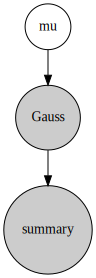

In [7]:
import elfi.examples.copula as copula_example

p = 3

m = copula_example.get_model(p)
# simulator = m['Gauss']
elfi.draw(m)

The informative indices of the summary statistic is defined in a dictionary where each index of the parameter $\theta$ corresponds to a set of summary statistic indices that are informative for that particular index.

In [8]:
informative_indices = {i: set([i]) for i in range(p)}
informative_indices[1] = {0, 1}
informative_indices

{0: {0}, 1: {0, 1}, 2: {2}}

The function `complete_informative_indices` completes the definition of the informative indices by adding all the pairwise unions of the univariate summary statistics.

In [9]:
full_indices = cop.complete_informative_indices(informative_indices); full_indices

{0: {0}, 1: {0, 1}, 2: {2}, (0, 1): {0, 1}, (0, 2): {0, 2}, (1, 2): {0, 1, 2}}

Next, we need to add the summary statistic and discrepancy nodes corresponding to the subsets we defined. The `make_distances` function adds summary and distance nodes corresponding to the specified indices. By default the ELFI model is copied instead of modifying it in place. This behavious can be changed with the `inplace` keyword.


Should the inference models be separate submodels instead?
===============================

In [10]:
summary = m['summary']
distance_nodes = cop.make_distances(full_indices, summary)

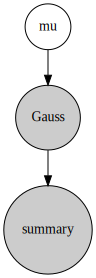

In [11]:
# The model is not modified in place by default
elfi.draw(m)

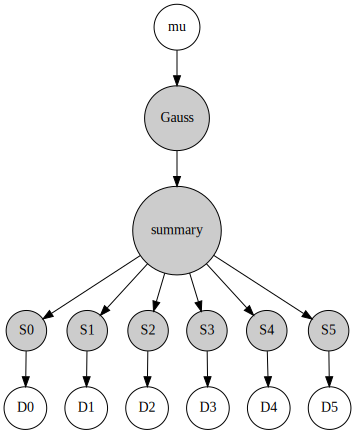

In [12]:
# Here is the modified model
elfi.draw(distance_nodes[0].model)

Finally, we must specify which ABC method to use for each of the submodels. The `make_samplers` function will construct a dictionary of sampling algorithms for each of the marginal distributions. The `sampler_factory` argument needs to be given a function which, given a discrepancy node, will produce an ABC method for sampling the corresponding subtree.

In [13]:
def Rejection(**kwargs):
    def wrapper(dist):
        return elfi.Rejection(dist, **kwargs)
    
    return wrapper

samplers = cop.make_samplers(distance_nodes, Rejection(batch_size=100)); samplers

{0: <elfi.methods.parameter_inference.Rejection at 0x7f8ec9b66518>,
 1: <elfi.methods.parameter_inference.Rejection at 0x7f8ec9ac6da0>,
 2: <elfi.methods.parameter_inference.Rejection at 0x7f8ec9ac6048>,
 (0, 1): <elfi.methods.parameter_inference.Rejection at 0x7f8eee56d400>,
 (0, 2): <elfi.methods.parameter_inference.Rejection at 0x7f8eee501d68>,
 (1, 2): <elfi.methods.parameter_inference.Rejection at 0x7f8eee517240>}

The `get_samples` function provides a convenient way to obtain samples from the marginal distributions.

In [14]:
# sample from the first component
sample0 = cop.get_samples(marginal=0, samplers=samplers, n_samples=10, parameter='mu', quantile=0.01)

# sample from the bivariate marginal of the first and second component
sample01 = cop.get_samples(marginal=(0, 1), samplers=samplers, n_samples=10, parameter='mu', quantile=0.1)
sample01

array([[  9.85393347,   1.02575079],
       [  9.53243287,  -0.05401075],
       [  9.98096432,   0.91640321],
       [  9.77504713,   1.60886578],
       [  9.72636471,  -1.72453311],
       [  8.40477993,  -4.28094187],
       [  9.09734377,  -1.4525115 ],
       [  7.42200576,  -3.76517224],
       [ 12.27778527,   3.37275352],
       [ 11.7130849 ,   3.20716874]])

Since we have $u_i = \Phi^{-1}(F_i(\theta_i))$ the correlations can be estimated using bivaraiate samples from $(\theta_i, \theta_j)$. First, let $r_i$ and $q_j$ be the ranks of the components of the bivariate sample respectively. The corresponding entry $\lambda_{i,j}$ in the correlation matrix $\Lambda$ is computed by setting $\eta_i = \Phi^{-1}(\frac{r_i}{n + a})$ and $\eta_j = \Phi^{-1}(\frac{q_j}{n + a})$ and computing the correlation coefficient between them. This can be done with the `estimate_correlation` function.

In [15]:
cop.estimate_correlation(marginal=(0, 1), samplers=samplers, parameter='mu', n_samples=100, quantile=0.01)

0.65748098067925798

In [16]:
# def prior(x, dim=p):
#     diag = np.ones(len(x))
#     diag[0] = 100
#     cov = np.diag(diag)
#     mvn = ss.multivariate_normal(cov=cov)
#     return mvn.pdf(inverse(x))

# def likelihood(theta, y=None, dim=p):
#     if y == None:
#         y = np.zeros(p)
#         y[0] = 10
#     return ss.multivariate_normal(mean=theta, cov=np.diag(np.ones(p))).pdf(y)

# def posterior_pdf(x, y=None, dim=p):
#     if y == None:
#         y = np.zeros(p)
#         y[0] = 10
        
#     #     evaluated at [x1, x2, 0, ..., 0]
#     theta = np.zeros(dim)
#     theta[:2] = x
#     return prior(theta, dim)*likelihood(theta, y, dim)

The `estimate` function combines all the previous steps to produce a meta-Gaussian approximation of the full posterior distribution.

In [18]:
posterior = cop.estimate(informative_indices, summary=m['summary'],
                         parameter='mu',
                         sampler_factory=Rejection(batch_size=1000),
                         n_samples=100, quantile=0.01)

 /u/18/skytenk1/unix/.conda/envs/elfi/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


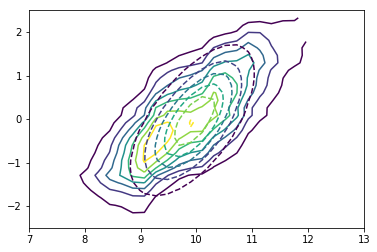

In [19]:
from elfi.visualization.visualization import compare, overlay
from elfi.utils import tabulate


def marginal(x, dim=p):
    """The posterior evaluated at [x1, x2, 0, 0, ..., 0]"""
    arr = np.zeros(dim)
    arr[:2] = x
    return posterior.pdf(arr)


t1 = np.linspace(7, 13, 30)
t2 = np.linspace(-2.5, 2.5, 30)

overlay({marginal: {}, posterior_pdf: {'linestyles': 'dashed'}}, t1, t2)

In [ ]:
# p = 30

# m2 = copula_example_model.get_model(p)
# d = elfi.Distance('euclidean', m2['Gauss'])
# rej = elfi.Rejection(d)
# res = rej.sample(n_samples=500, quantile=0.01)

# post = res.outputs['mu'][:, [0, 1]]

# plt.scatter(post[:, 0], post[:, 1])

# kde = ss.gaussian_kde(np.transpose(post))

# kde.pdf(np.array([0,0]))

# overlay({kde.pdf: {}, posterior_pdf: {}}, t1, t2)